In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

/Users/imachome/anaconda3/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Пример анализа доходности торговой стратегии на базе исторических данных.

In [2]:
class SmaCross(Strategy):
    
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
display(stats)

bt.plot()

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   97.067039
Equity Final [$]                  68221.96986
Equity Peak [$]                   68991.21986
Return [%]                         582.219699
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   25.266427
Volatility (Ann.) [%]               38.383008
Sharpe Ratio                         0.658271
Sortino Ratio                        1.288779
Calmar Ratio                         0.763748
Max. Drawdown [%]                  -33.082172
Avg. Drawdown [%]                   -5.581506
Max. Drawdown Duration      688 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                   94
Win Rate [%]                        54.255319
Best Trade [%]                       57.11931
Worst Trade [%]                    -16.629898
Avg. Trade [%]                    

Row(id='1450', ...)

Давайте разбираться как это работает.

Подмодули библиотеки `backtesting.py`:
    
`backtesting.backtesting` - [Базовые структуры данных. Объекты из этого модуля также можно импортировать напрямую из модуля верхнего уровня.](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0)

`backtesting.lib` - 
[Коллекция общих строительных блоков, вспомогательных функций и составных классов стратегий для повторного использования](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#gsc.tab=0)

`backtesting.test` - 
[Данные и утилиты для тестирования](https://kernc.github.io/backtesting.py/doc/backtesting/test/index.html#gsc.tab=0)




**Основная информация подчерпнута из справки в виде перевода и собственных коментариев.**


# Общее


`backtesting.py` - это небольшой и легкий, невероятно быстрый фреймворк для oцeнки эффeктивнocти тopгoвых стратегий нa ocнoвe иcтopичecкиx дaнныx (в дальнейшем просто - бэктестинг), который использует самые современные структуры и процедуры Python (Python 3.6+, Pandas, NumPy, Bokeh). 
Он имеет достаточно простой и краткий API, который легко запоминается и быстро работает. 

Библиотека **не поддерживает выбор акций или торговые стратегии, основанные на арбитраже или перебалансировке портфеля с несколькими активами**. 

Библиотека **работает с отдельным торгуемым активом** и лучше всего подходит для оптимизации стратегий сигналов входа в позицию и выхода из нее, принятия решений на основе значений технических индикаторов, а также является универсальным интерактивным инструментом визуализации торговли и статистики.

# Данные

Можно использовать любые данные в формате OHLC (биржы, валюта, фьючерсы, ...) в виде `pandas.DataFrame` с колонками  `Open`, `High`, `Low`, `Close` и (опционально) `Volume`. Such data is widely obtainable (see: pandas-datareader, Quandl, findatapy). Помимо этого, ваши `pandas.DataFrame` данных могут содержать дополнительные столбцы, которые будут доступны в ваших стратегиях.

`DataFrame` в идеале должен быть проиндексирован `datetime index` (используем `pd.to_datetime()`), можно (но не желательно) использовать обычные индексы, не содержащие дубликатов.

Возьмем пример из библиотеки в качестве образца (а так можно использовать `yfinance`):

In [3]:
from backtesting.test import GOOG

GOOG.tail()

,Open,High,Low,Close,Volume
2013-02-25,802.3,808.41,790.49,790.77,2303900
2013-02-26,795.0,795.95,784.40,790.13,2202500
2013-02-27,794.8,804.75,791.11,799.78,2026100
2013-02-28,801.1,806.99,801.03,801.20,2265800
2013-03-01,797.8,807.14,796.15,806.19,2175400


# Статегия

Давайте создадим нашу первую стратегию для тестирования на основе этих данных Google, основанную на пересечении двух скользящих средних.

`Backtesting.py` не предоставляет свой собственный набор индикаторов технического анализа. 

Пользователи использующие индикаторы технического анализа рекомендуется использовать функции из проверенных библиотек индикаторов технического анализа, таких как [TA-Lib](https://ta-lib.github.io/ta-lib-python/index.html) или [Tulipy](https://tulipindicators.org), но для этого примера мы можем сами определить простую вспомогательную функцию скользящего среднего:

In [4]:
def SMA(values, n):
    """
    Возвращает простое скользящее среднее значение `values`,
    в окне из `n` значений.
    """
    return pd.Series(values).rolling(n).mean()

Новая стратегия должна расширить класс `Strategy` и переопределить два его абстрактных метода: `init()` и `next()`.

Метод `init()` вызывается перед запуском стратегии. В рамках него выполняется предварительный расчет любых индикаторов и сигналов, от которых зависит стратегия, в идеале максимально эффективно.

Затем нужно определить метод `next()`, который  итеративно вызывается экземпляром `Backtest`, по одному разу для каждой точки данных (строки датафрейма), имитируя пошаговую, поочередную доступность каждого нового столбца свечи OHLC.

Обратите внимание, `Backtesting.py` **не может принимать решения или совершать сделки внутри свечей** — любые новые **ордера исполняются при открытии следующей свечи** (или закрытии текущей свечи, если `trade_on_close=True`). Если вы решите торговать с использованием данных внутри свечей (например внутри дневная торговля), вам вместо этого нужно использовать с более детализированные данные (например, почасовые).

In [5]:
class SmaCross(Strategy):
    # Определите два запаздывания MA как **переменные класса**
    # для последующей оптимизации
    n1 = 10
    n2 = 20
    
    def init(self):
        # Предварительно вычислим две скользящие средние
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # Если sma1 пересекается выше sma2, закройте все существующие короткие позиции
        # и купите актив
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # В противном случае, если sma1 пересечется ниже sma2, закройте все существующие 
        # длинные сделки и продайте актив
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

В функции `init()`, а также в `next()` обрабатываются данные, на основе которых моделируется стратегия, данные передаются в переменной экземпляра `self.data`.

В `init()` мы объявляем и вычисляем индикаторы косвенно, заключая их в `self.I()`. Оболочке передается функция (наша SMA-функция) вместе с любыми аргументами для ее вызова (наши значения close и задержка MA). Индикаторы, обернутые таким образом, будут автоматически нанесены на график, а строки условных обозначений для них будут выведены с помощью встроенного анализа данных библиотеки.

В `next()` мы просто проверяем, пересекла ли более быстрая скользящая средняя только что более медленную. Если это произошло и вверх, мы закрываем возможную короткую позицию и открываем длинную позицию; если это произошло и вниз, мы закрываем открытую длинную позицию и открываем короткую позицию. 
Обратите внимание, что мы не корректируем размер заказа, поэтому проведите `Backtesting.py` принимает максимально возможное положение. 

Мы используем функцию `backtesting.lib.crossover()` вместо того, чтобы писать более сложные и запутанные условия, такие как:

In [6]:
def next(self):
    if (self.sma1[-2] < self.sma2[-2] and
            self.sma1[-1] > self.sma2[-1]):
        self.position.close()
        self.buy()

    elif (self.sma1[-2] > self.sma2[-2] and    
          self.sma1[-1] < self.sma2[-1]):
        self.position.close()
        self.sell()

В `init()` был доступен весь ряд точек, тогда как в `next()` длина `self.data` и всех объявленных индикаторов корректируется при каждом вызове `next()`, так что `array[-1]` (например, self.data. Close[-1] или self.sma1[-1]) всегда содержит самое последнее значение, `array[-2]` — предыдущее значение и т. д.

Примечание: `self.data` и любые индикаторы, заключенные в `self.I` (например, `self.sma1`), являются массивами NumPy из соображений производительности. 
Если вы предпочитаете объекты  pandas Series или DataFrame, используйте средства доступа `Strategy.data.<column>.s` или `Strategy.data.df` соответственно. Вы также можете построить Series вручную, например. `pd.Series(self.data.Close, index=self.data.index)`.

Мы могли бы избежать вызовов `self.position.close()`, если бы запустили экземпляр `Backtest` с помощью `Backtest(..., exclusive_orders=True)`.

## Тестирование на исторических данных (бэктестинг)

Давайте посмотрим, как наша стратегия работает на исторических данных Google. Экземпляр `Backtest` инициализируется данными OHLC и классом стратегии, и мы начинаем с 10 000 единиц наличных и устанавливаем комиссию брокера на  уровне 0.2%.

In [20]:
bt = Backtest(GOOG, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   97.067039
Equity Final [$]                  68221.96986
Equity Peak [$]                   68991.21986
Return [%]                         582.219699
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   25.266427
Volatility (Ann.) [%]               38.383008
Sharpe Ratio                         0.658271
Sortino Ratio                        1.288779
Calmar Ratio                         0.763748
Max. Drawdown [%]                  -33.082172
Avg. Drawdown [%]                   -5.581506
Max. Drawdown Duration      688 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                   94
Win Rate [%]                        54.255319
Best Trade [%]                       57.11931
Worst Trade [%]                    -16.629898
Avg. Trade [%]                    

Метод `Backtest.run()` возвращает серию результатов моделирования в формате pandas и статистику, связанную с нашей стратегией. Мы видим, что эта простая стратегия приносит доходность почти в 600% за 9 лет, при максимальной просадке в 33% и при самом длительном периоде просадки, охватывающем почти два года...

Метод `Backtest.plot()` предоставляет ту же информацию в более наглядной форме.

In [8]:
bt.plot()

Row(id='2182', ...)

## Оптимизация 

Мы жестко определили два параметра окна для скользящей средней - n1 и n2. Однако наша стратегия может лучше работать в окне с другим размером, например в диапазоне с 15-30. Давайте сделаем эти параметры оптимизируемыми.

Мы оптимизируем два параметра, вызывая метод `Backtest.optimize()` с каждым параметром в качестве ключевого аргумента, указывающего на его перечень возможных значений для тестирования. 

Параметр n1 проверяется на значения в диапазоне от 5 до 30, а параметр n2 - на значения от 10 до 70, соответственно. 

Некоторые комбинации значений двух параметров недопустимы, т.к. n1 не должно быть больше или равно n2. Мы ограничим допустимые комбинации параметров специальной функцией, которая принимает параметры и возвращает значение True (как допустимые) всякий раз, когда n1 меньше n2. 
Кроме того, мы ищем такую комбинацию параметров, которая максимизирует доходность за наблюдаемый период. 

Вместо данного оптимизатора мы могли бы выбрать оптимизацию любых других ключей.

In [9]:
stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]', # выбираем поле для максимизации
                    constraint = lambda param: param.n1 < param.n2)
stats

/Users/imachome/anaconda3/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/7 [00:00<?, ?it/s]

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   99.068901
Equity Final [$]                 103949.42612
Equity Peak [$]                  108327.71798
Return [%]                         939.494261
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   31.610936
Volatility (Ann.) [%]               44.739816
Sharpe Ratio                          0.70655
Sortino Ratio                        1.490961
Calmar Ratio                         0.718505
Max. Drawdown [%]                  -43.995445
Avg. Drawdown [%]                   -6.138853
Max. Drawdown Duration      690 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                  153
Win Rate [%]                        51.633987
Best Trade [%]                      61.562908
Worst Trade [%]                    -19.778312
Avg. Trade [%]                    

In [10]:
stats._strategy

<Strategy SmaCross(n1=10,n2=15)>

In [11]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='2791', ...)

С помощью оптимизации удалось повысить первоначальную доходность на выборочных данных почти на 50% и даже превзойти статегию купить и держать. 

## Анализ торговых результатов



In [12]:
stats.tail()

Expectancy [%]                                              1.97988
SQN                                                        1.604158
_strategy                                     SmaCross(n1=10,n2=15)
_equity_curve                       Equity  DrawdownPct Drawdown...
_trades                Size  EntryBar  ExitBar  EntryPrice  Exit...
dtype: object

Содержит кривые эквити / просадки. Продолжительность просадки определяется только в конце периодов DD.

In [13]:
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2004-08-19,10000.00000,0.000000,NaT
2004-08-20,10000.00000,0.000000,NaT
2004-08-23,10000.00000,0.000000,NaT
2004-08-24,10000.00000,0.000000,NaT
2004-08-25,10000.00000,0.000000,NaT
...,...,...,...
2013-02-25,103035.52612,0.048854,NaT
2013-02-26,102952.32612,0.049622,NaT
2013-02-27,104206.82612,0.038041,NaT
2013-02-28,104391.42612,0.036337,NaT


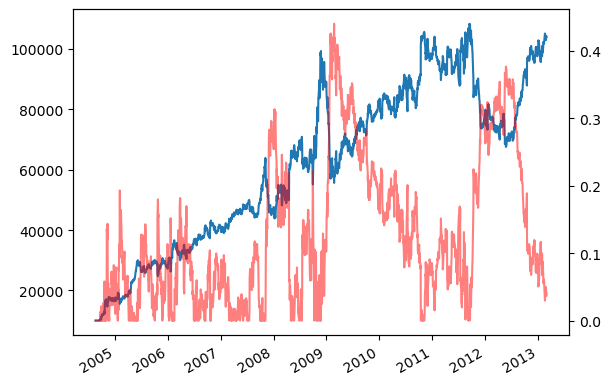

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
stats['_equity_curve']['Equity'].plot(ax = ax1) # график роста/падения размера торгового счета
stats['_equity_curve']['DrawdownPct'].plot(ax = ax2, 
                                           color = 'red', alpha=0.5); # процент просадки(падения) размера торгового счета

In [15]:
# период просадки счета между пиками
stats['_equity_curve'][stats['_equity_curve']['DrawdownDuration'].notna()]

,Equity,DrawdownPct,DrawdownDuration
2004-09-23,10536.89092,0.000000,3 days
2004-09-28,11062.37092,0.000000,5 days
2004-10-01,11560.01092,0.000000,2 days
2004-10-07,12105.50092,0.000000,2 days
2004-10-13,12283.85092,0.000000,6 days
...,...,...,...
2010-10-26,104306.41950,0.000000,8 days
2010-11-03,104571.85950,0.000000,8 days
2011-09-07,106630.24798,0.000000,303 days
2011-09-15,108327.71798,0.000000,7 days


In [16]:
stats['_trades']  # Детальные данные по торговой стратегии

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,87,20,60,114.64884,185.23,6140.56092,0.615629,2004-09-17,2004-11-12,56 days
1,-87,60,69,184.85954,175.80,788.17998,0.049008,2004-11-12,2004-11-26,14 days
2,96,69,71,176.15160,180.71,437.60640,0.025878,2004-11-26,2004-11-30,4 days
3,-96,71,75,180.34858,179.13,116.98368,0.006757,2004-11-30,2004-12-06,6 days
4,97,75,82,179.48826,177.99,-145.33122,-0.008347,2004-12-06,2004-12-15,9 days
...,...,...,...,...,...,...,...,...,...,...
148,139,2085,2111,689.15556,735.54,6447.43716,0.067306,2012-11-29,2013-01-08,40 days
149,-139,2111,2113,734.06892,742.83,-1217.79012,-0.011935,2013-01-08,2013-01-10,2 days
150,136,2113,2121,744.31566,735.99,-1132.28976,-0.011186,2013-01-10,2013-01-23,13 days
151,-136,2121,2127,734.51802,750.51,-2174.90928,-0.021772,2013-01-23,2013-01-31,8 days


1. `Size` - количество бумаг
2. `EntryBar` - номер бара октрытия позиции
3. `ExitBar` - номер бара закрытия позиции
4. `EntryPrice` - цена открытия позиции
5. `ExitPrice` - цена закрытия позиции
6. `PnL` (Profit and Loss statement) - отчёт о прибылях и убытках
7. `ReturnPct` - рост/убытки в процентах
8. `EntryTime` - дата открытия позиции
9. `ExitTime` - дата закрытия позиции
10. `Duration` - длительность открытой позиции
